In [1]:
import tensorflow as tf
import optuna
import shap
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.optimizers.legacy import RMSprop

In [2]:
df = pd.read_csv('prepared_LOB_trunc_data.csv',
                 index_col=0) # if this file is read, you could start from cell number 17
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_ask_prices_1,time_bid_prices_2,time_ask_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
999,2023-10-02 00:00:06.051655936,27993.64,27996.08,0.072713,0.188,27993.41,27996.38,0.150000,0.060000,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1000,2023-10-02 00:00:06.051817984,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105453
1001,2023-10-02 00:00:06.051911168,27993.64,27996.08,0.072713,0.188,27993.41,27996.99,0.150000,0.177791,27993.40,...,0,1,0,1,0,1,0,-0.442198,27995.399481,494.105386
1002,2023-10-02 00:00:06.051913984,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065679
1003,2023-10-02 00:00:06.052875008,27993.41,27996.08,0.150000,0.188,27993.40,27996.99,0.250000,0.177791,27992.96,...,0,1,0,1,0,1,0,-0.112426,27994.895089,494.065680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020,27968.26,27970.25,0.020000,0.053564,27967.98,...,0,1,0,1,0,1,0,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020,27968.27,27970.25,0.171501,0.053564,27968.26,...,0,1,0,1,0,1,0,0.775408,27968.500100,74.790948


In [3]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    if 'bid' in column:
      repr_column = 'ask_prices_0'
    else:
      repr_column = 'bid_prices_0'
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[repr_column]>num][repr_column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
    return time

In [4]:
columns = ['bid_prices_0', 'ask_prices_0', 'bid_prices_1','ask_prices_1', 'bid_prices_2', 'ask_prices_2', 
           'bid_prices_3', 'ask_prices_3', 'bid_prices_4', 'ask_prices_4']

In [ ]:
for column in columns:
  df['time_'+column] = finder_of_fulfilment(df, column)

In [ ]:
for column in columns:
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),4)

In [ ]:
def plot_KM_estimator(column):
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df[df['time_'+column]==time])
      num_survived = len(df[df['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)


  S_hat = np.cumprod(S_of_t)
  return S_hat, times

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for column in columns:
  KM_est, times = plot_KM_estimator(column)
  if 'bid' in column:
    ax1.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]}, 
             {column.split('_')[0]} pegged")
    ax1.set_xlabel('t (sec.)')
    ax1.set_ylabel('$\hat{S}(t)$')
    ax1.set_title('Bid Survival Probability Over Time')
    ax1.legend()
    ax1.grid(True)

  else:
    ax2.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]},
             {column.split('_')[0]} pegged")
    ax2.set_xlabel('t (sec.)')
    ax2.set_ylabel('$\hat{S}(t)$')
    ax2.set_title('Ask Survival Probability Over Time')
    ax2.legend()
    ax2.grid(True)

plt.show()

In [ ]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

In [ ]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

In [ ]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

In [ ]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

In [ ]:
threshold=1
for column in columns:
  df['time_' + column] = df['time_' + column].apply(lambda x: 1 if x < threshold else 0)

In [ ]:
df.dropna(inplace=True)
df.describe()

In [5]:
df.to_csv('prepared_LOB_trunc_data.csv')

In [5]:
N = 500  # Define the number of previous observations included

# Assuming 'columns' is a list of column names and 'column' is a specific column name
columns_to_drop = ['time_' + col for col in columns] + ['timestamp']
X = df.drop(columns=columns_to_drop).iloc[:len(df)//10]
Y = df[['time_' + col for col in columns if 'ask_prices_0' in col]].iloc[N:len(df)//10].values

print(Y.shape)

(9708, 1)


In [6]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

X.shape

2024-01-04 17:06:56.733831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-04 17:06:56.733959: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-04 17:06:56.734000: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-04 17:06:56.734223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 17:06:56.734325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([9708, 501, 23])

,time_ask_prices_0,time_ask_prices_1,time_ask_prices_2,time_ask_prices_3,time_ask_prices_4
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.337501,0.281920,0.225285,0.179897,0.146207
std,0.472869,0.449946,0.417780,0.384111,0.353322
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


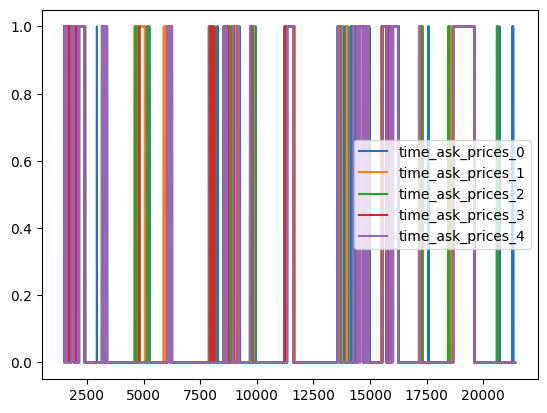

In [7]:
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)//5].plot()
df[['time_' + col for col in columns if 'ask' in col]].iloc[N:len(df)//5].describe()

In [8]:
print('X shape :', X.shape)
print('Y shape :',Y.shape[0])

X shape : (9708, 501, 23)
Y shape : 9708


In [9]:
X_np = X.numpy()

# Now use train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y, test_size=0.2, shuffle=False)

In [10]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train.ravel()),  # Ensure Y_train is 1-dimensional
    y=Y_train.ravel()                    # Ensure Y_train is 1-dimensional
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.7974943520230027, 1: 1.3403520883672766}

In [11]:
bias_initializer =  -np.log(np.count_nonzero(Y_train)/(len(Y_train)-np.count_nonzero(Y_train)))
bias_initializer

0.5192128584133505

In [12]:
import tensorflow as tf

class Encoder(tf.keras.Model):
    def __init__(self, filters, kernel_size_Q, kernel_size_K, kernel_size_V, units,
                 dilation_rate, num_heads, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.dilation_rate = dilation_rate

        # Define Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Define Dilated Convolution layers for Q, K, V
        self.dilated_conv_Q1 = self._create_conv_block(filters, kernel_size_Q)
        self.dilated_conv_K1 = self._create_conv_block(filters, kernel_size_K)
        self.dilated_conv_V1 = self._create_conv_block(filters, kernel_size_V)

        # Global Average Pooling layer
        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

        # Multi-Head Attention layer with Layer Normalization
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=units)
        self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def _create_conv_block(self, filters, kernel_size):
        """Helper function to create a convolutional block."""
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                   dilation_rate=self.dilation_rate, padding='same', 
                                   activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            self.dropout
        ])

    def call(self, inputs):
        # Apply convolutional block to Q, K, V
        Q = self.dilated_conv_Q1(inputs)
        Q = self.global_avg_pooling(Q)
        Q = tf.expand_dims(Q, axis=1)  # Reshape for attention layer

        K = self.dilated_conv_K1(inputs)
        K = self.global_avg_pooling(K)
        K = tf.expand_dims(K, axis=1)  # Reshape for attention layer

        V = self.dilated_conv_V1(inputs)
        V = self.global_avg_pooling(V)
        V = tf.expand_dims(V, axis=1)  # Reshape for attention layer

        # Multi-Head Attention with Layer Normalization
        attention_output = self.multi_head_attention(Q, K, V)
        attention_output = self.attention_norm(attention_output)

        return attention_output

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, units, num_dense_layers=10, dropout_rate=0.1):
        super(Decoder, self).__init__()

        # Flatten layer
        self.flatten = tf.keras.layers.Flatten()

        # Dense layers with batch normalization and dropout
        self.dense_layers = []
        for _ in range(num_dense_layers):
            self.dense_layers.append(tf.keras.Sequential([
                tf.keras.layers.Dense(units=32, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(dropout_rate)
            ]))

        # Self-Attention layers
        self.attention_layers = [SeqSelfAttention(units=units, attention_activation='relu', 
                                                  attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL) 
                                 for _ in range(2)]

    def call(self, x):
        x = self.flatten(x)
        x = tf.expand_dims(x, -1)

        # Apply dense layers with residual connections
        for i, layer in enumerate(self.dense_layers):
            original_x = x
            x = layer(x)
            if (i + 1) % 2 == 0:  # Apply residual connection every 2 layers
                x = x + original_x  # Add the input x to the output of two dense layers

        # Apply attention layers
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return x

In [14]:
def create_full_model(input_shape, filters, num_heads, d_model, units, 
                      kernel_size_Q, kernel_size_K, kernel_size_V):
    # Reshape the input to add a channel dimension
    encoder_inputs = layers.Input(shape=input_shape)
    reshaped_inputs = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(encoder_inputs)

    # Create an instance of the Encoder
    encoder = Encoder(filters=filters, kernel_size_Q=kernel_size_Q, kernel_size_K=kernel_size_K, 
                      kernel_size_V=kernel_size_V, units=d_model, dilation_rate=1, num_heads=num_heads)

    # Get the output from the encoder
    encoder_output = encoder(reshaped_inputs)

    # Create an instance of the Decoder
    decoder = Decoder(units=d_model)

    # Get the output from the decoder
    decoder_output = decoder(encoder_output)

    # Flatten and final layers
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(flat_output)

    # Create the model
    model = tf.keras.Model(inputs=encoder_inputs, outputs=output)
    return model

In [15]:
print(X_train.shape, Y_train.shape)

(7766, 501, 23) (7766, 1)


In [16]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = 1
filters = 32
units = 4
kernel_size_Q, kernel_size_K, kernel_size_V = 4,4,4
num_heads = 3
d_model = 2
batch = 16

In [19]:
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, units, 
                          kernel_size_Q, kernel_size_K, kernel_size_V)
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Train the model with a validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)

model.fit(x=X_train, y=Y_train,
          batch_size=batch,
          epochs=100,
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_test, Y_test))

Epoch 1/100
996/996 [==============================] - 380s 324ms/step - loss: 0.8987 - accuracy: 1.0000 - precision: 0.3547 - recall: 0.5021 - auc: 0.5081 - val_loss: 0.6325 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5553
Epoch 2/100
996/996 [==============================] - 2161s 2s/step - loss: 0.7810 - accuracy: 1.0000 - precision: 0.3458 - recall: 0.4858 - auc: 0.5006 - val_loss: 1.0351 - val_accuracy: 1.0000 - val_precision: 0.3015 - val_recall: 1.0000 - val_auc: 0.5836
Epoch 3/100
996/996 [==============================] - 565s 568ms/step - loss: 0.7609 - accuracy: 1.0000 - precision: 0.3461 - recall: 0.4916 - auc: 0.5024 - val_loss: 0.6888 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/100
996/996 [==============================] - 272s 274ms/step - loss: 0.7540 - accuracy: 1.0000 - precision: 0.3421 - recall: 0.4950 - auc: 0.4971 - val_loss: 0.7483 - val_accuracy: 1.0000 - val

loss is pretty low but the model's perf is awfull

In [20]:
Y_pred = model.predict(X_test)

125/125 [==============================] - 17s 66ms/step


[]

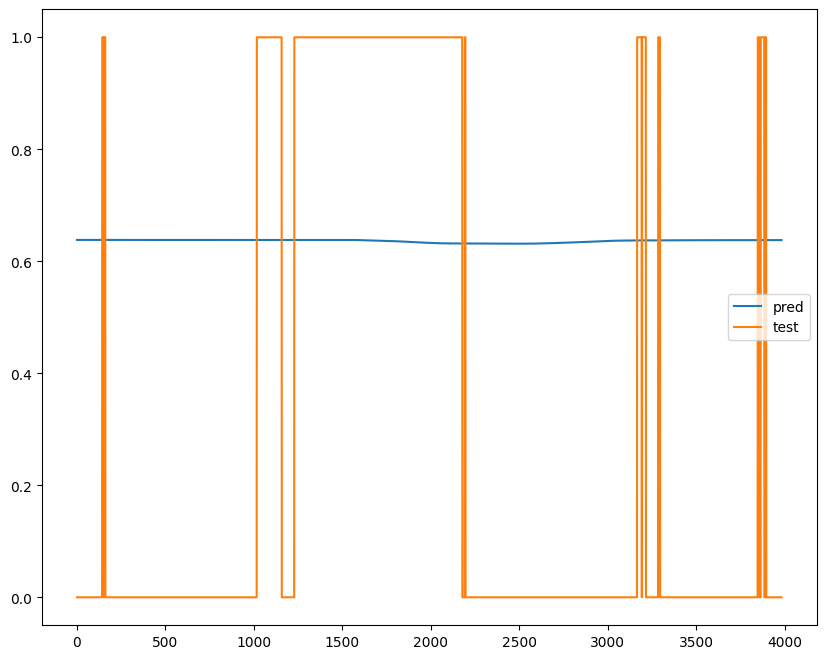

In [21]:
plt.figure(figsize=(10,8))
plt.plot(Y_pred, label='pred')
plt.plot(Y_test, label='test')
plt.legend()
plt.plot()

# Training Visualization

In [ ]:
optimizer = RMSprop(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, gradients

def plot_distribution(data, title):
    plt.hist(data.flatten(), bins=50)
    plt.title(title)
    plt.show()

# Assuming X and Y are your data and labels
for epoch in range(3):
    for step in range(0, len(X_train), batch):
        x_batch = X_train[step:step + batch]
        y_batch = Y_train[step:step + batch]

        loss, gradients = train_step(model, x_batch, y_batch)

        # Every N steps, visualize weights, activations, and gradients
        if step % 100 == 0:
            # Visualize weights and gradients
            for var, grad in zip(model.trainable_variables, gradients):
                plot_distribution(var.numpy(), f'Weights of {var.name}')
                plot_distribution(grad.numpy(), f'Gradients of {var.name}')

            # Visualize activations
            intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for 
                                                                             layer in model.layers])
            activations = intermediate_model.predict(x_batch)
            for i, activation in enumerate(activations):
                plot_distribution(activation, f'Activation of layer {i+1}')

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])
    filters = trial.suggest_categorical('filters', [2, 64])
    units = trial.suggest_categorical('units', [4, 8, 16])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [8, 16])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [3, 9])
    dilation_rate = trial.suggest_categorical('dilation_rate', [2, 3, 16])
    d_model = trial.suggest_categorical('d_model', [1, 8])
    batch = trial.suggest_categorical('batch', [32, 64])

    # Create the model
    model = create_full_model(input_shape, filters, num_heads, d_model, units, 
                              kernel_size_Q, kernel_size_K, kernel_size_V)
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='Hinge',
                  metrics=[#tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc')])
    
    print(filters, num_heads, d_model, units, kernel_size_Q, kernel_size_K, kernel_size_V)
    
    # Train the model with a validation set
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    
    
    history = model.fit(x=X_train, y=Y_train, 
              batch_size=batch, 
              epochs=10, 
              callbacks=[callback],
              class_weight=class_weights_dict,
              validation_data=(X_test, Y_test))  # Include validation data here

    val_loss = history.history['val_auc'][-1]
    
    return val_loss

# Optuna study
study = optuna.create_study(direction='maximize')  # 'minimize' if lower is better, 'maximize' otherwise
study.optimize(objective, n_trials=10)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-01-04 17:07:25,318] A new study created in memory with name: no-name-4288867e-462a-40d0-9d26-75eac160fdf0


64 4 8 4 8 2 9
Epoch 1/10


2024-01-04 17:07:29.336923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 131s 633ms/step - loss: 0.9997 - precision: 0.3750 - recall: 0.0942 - auc: 0.5003 - val_loss: 1.4398 - val_precision: 0.1359 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/10
122/122 [==============================] - 44s 356ms/step - loss: 0.9971 - precision: 0.3779 - recall: 0.5257 - auc: 0.5011 - val_loss: 1.1145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
122/122 [==============================] - 44s 360ms/step - loss: 1.0026 - precision: 0.3727 - recall: 0.7563 - auc: 0.4876 - val_loss: 1.6285 - val_precision: 0.1359 - val_recall: 1.0000 - val_auc: 0.5176
Epoch 4/10
122/122 [==============================] - 44s 357ms/step - loss: 0.9970 - precision: 0.3745 - recall: 0.6562 - auc: 0.5029 - val_loss: 1.0056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 5/10
122/122 [==============================] - 43s 355ms/step - loss: 1.0012 - precision: 0.3689 - recall: 0.4101 - auc

[I 2024-01-04 17:13:17,044] Trial 0 finished with value: 0.5 and parameters: {'num_heads': 4, 'filters': 64, 'units': 4, 'kernel_size_Q': 8, 'kernel_size_K': 2, 'kernel_size_V': 9, 'dilation_rate': 3, 'd_model': 8, 'batch': 64}. Best is trial 0 with value: 0.5.


64 8 8 8 8 4 9
Epoch 1/10
243/243 [==============================] - 190s 513ms/step - loss: 1.0011 - precision: 0.2917 - recall: 0.0048 - auc: 0.4974 - val_loss: 1.7274 - val_precision: 0.1359 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/10
243/243 [==============================] - 84s 344ms/step - loss: 1.0001 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4997 - val_loss: 1.3319 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4800
Epoch 3/10
243/243 [==============================] - 84s 344ms/step - loss: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 1.1377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/10
169/243 [===================>..........] - ETA: 22s - loss: 0.9989 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = 1
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size_Q = trial.params['kernel_size_Q']
kernel_size_K = trial.params['kernel_size_K']
kernel_size_V = trial.params['kernel_size_V']
batch = trial.params['batch']
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, units, 
                              kernel_size_Q, kernel_size_K, kernel_size_V)

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# Train the model with a validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5)


history = model.fit(x=X_train, y=Y_train, 
          batch_size=batch, 
          epochs=100, 
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_test, Y_test))

In [25]:
Y_pred = model.predict(X_test)

125/125 [==============================] - 21s 134ms/step


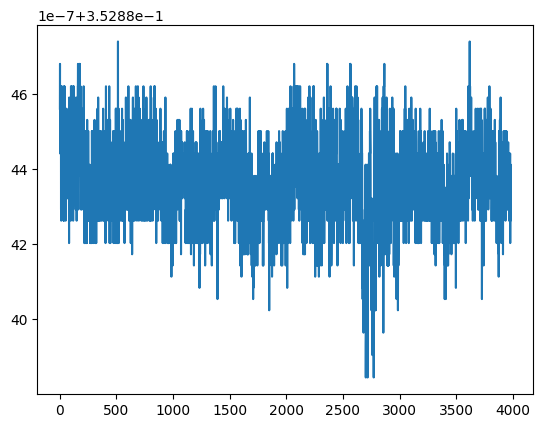

In [26]:
plt.plot(Y_pred, label='pred')
#plt.plot(Y_test, label='actual')

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

input_shape = (N+1, 23)

toy_model = Sequential()

# Using LSTM for sequential data
toy_model.add(LSTM(64, return_sequences=True, input_shape=input_shape))

toy_model.add(LSTM(32, return_sequences=True))

# SeqSelfAttention layer
toy_model.add(SeqSelfAttention(units=1, attention_activation='sigmoid', 
                               attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))

# Flatten the output to feed into a Dense layer
toy_model.add(Flatten())

# Dense layer(s) and Output layer
toy_model.add(Dense(64, activation='relu'))
toy_model.add(Dense(1, activation='sigmoid'))

# Compile the model
toy_model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[CategoricalAccuracy(), Precision(), Recall(), AUC()])

# Model summary
toy_model.summary()

history = model.fit(x=X_train, y=Y_train, 
          batch_size=batch, 
          epochs=100, 
          callbacks=[callback],
          class_weight=class_weights_dict,
          validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 501, 64)           22528     
                                                                 
 lstm_5 (LSTM)               (None, 501, 32)           12416     
                                                                 
 seq_self_attention_8 (SeqS  (None, 501, 32)           1025      
 elfAttention)                                                   
                                                                 
 flatten_8 (Flatten)         (None, 16032)             0         
                                                                 
 dense_37 (Dense)            (None, 64)                1026112   
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                      

125/125 [==============================] - 6s 27ms/step


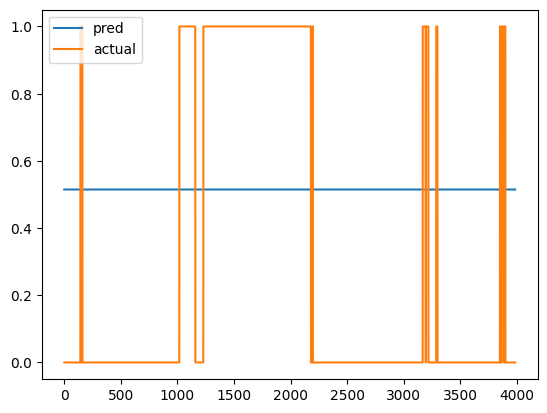

In [31]:
Y_toy_pred = toy_model.predict(X_test)
plt.plot(Y_toy_pred, label='pred')
plt.plot(Y_test, label='actual')
plt.legend()

In [ ]:
explainer = shap.TreeExplainer(toy_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,
    feature_names=X.columns,
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])